In [62]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import (
    load_data_assets,
    load_benchmark,
    load_risk_free,
)

# Settings
sns.set(style="whitegrid", palette="muted", context="notebook")
plt.rcParams['figure.figsize'] = (12,6)

window = 20

## LOAD DATA
Load historical stock prices, benchmark (S&P 500), and risk-free rate (TNX).

In [63]:
tickers = ["MSFT", "AMZN", "AAPL"]
df_assets = load_data_assets(tickers)
sp500 = load_benchmark()
rf = load_risk_free()

/home/fstrasser/Documents/repositories/Final_DataProjet_Github-main/src/data_loader.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/home/fstrasser/Documents/repositories/Final_DataProjet_Github-main/src/data_loader.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/home/fstrasser/Documents/repositories/Final_DataProjet_Github-main/src/data_loader.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/home/fstrasser/Documents/repositories/Final_DataProjet_Github-main/src/data_loader.py:26: FutureWarning: YF.download() has changed argumen

 We now have:
 - Individual stock DataFrames in `df_assets`
 - Benchmark data `sp500`
 - Rolling 20-day risk-free rate `rf`

## Prepare Portfolio and Benchmark Prices
 Create a DataFrame containing closing prices for all portfolio assets

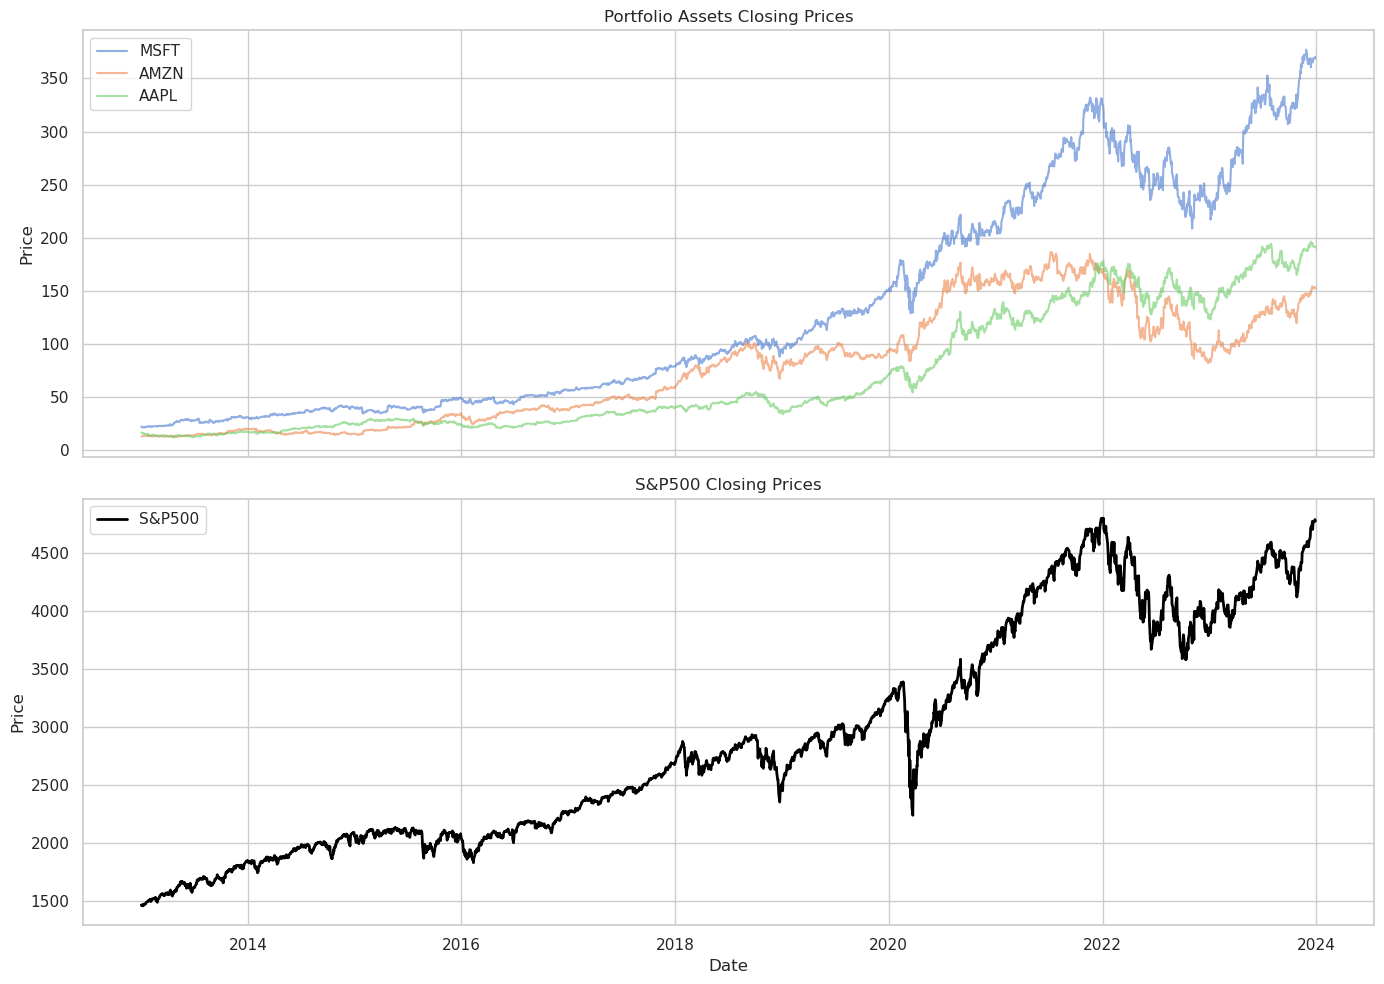

In [64]:
portfolio_prices = pd.concat([df["Close"] for df in df_assets.values()], axis=1)
portfolio_prices.columns = df_assets.keys()
portfolio_prices = portfolio_prices.dropna()

sp500_prices = sp500['Close']

# Plot raw prices
fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True)

# Subplot 1: Portfolio assets
for col in portfolio_prices.columns:
    axes[0].plot(portfolio_prices[col], alpha=0.6, label=col)
axes[0].set_title("Portfolio Assets Closing Prices")
axes[0].set_ylabel("Price")
axes[0].legend()

# Subplot 2: S&P500
axes[1].plot(sp500_prices, color="black", label="S&P500", linewidth=2)
axes[1].set_title("S&P500 Closing Prices")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price")
axes[1].legend()

plt.tight_layout()
plt.show()

## Normalize Prices
Normalize prices to compare relative evolution.

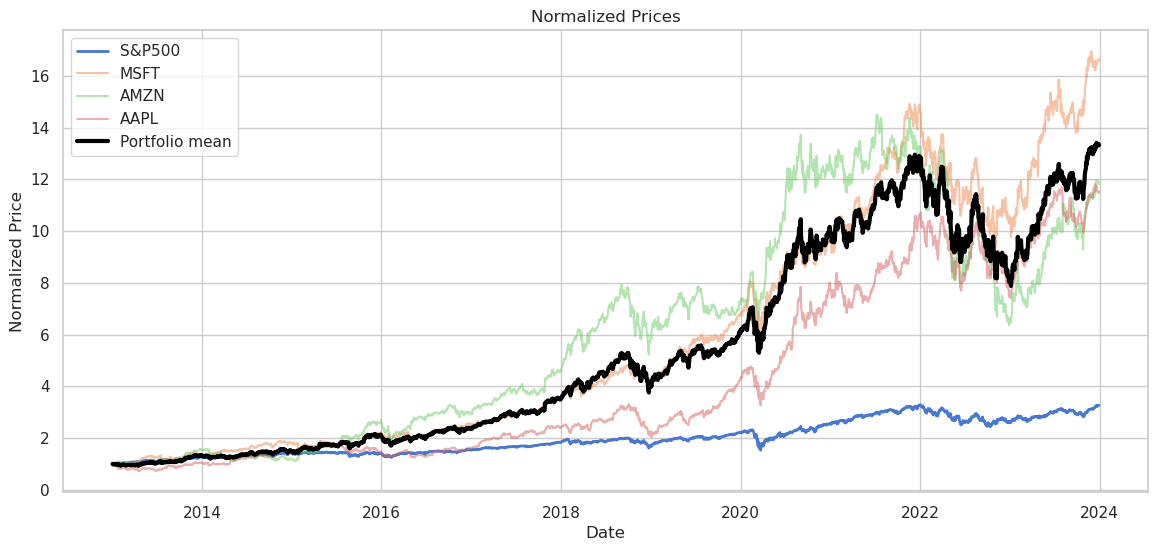

In [65]:
portfolio_norm = portfolio_prices / portfolio_prices.iloc[0]
portfolio_norm['mean'] = portfolio_norm.mean(axis=1)
sp500_norm = sp500_prices / sp500_prices.iloc[0]

plt.figure(figsize=(14,6))
plt.plot(sp500_norm, label="S&P500", linewidth=2)
for col in portfolio_norm.columns[:-1]:
    plt.plot(portfolio_norm[col], alpha=0.5, label=col)
plt.plot(portfolio_norm['mean'], label="Portfolio mean", linewidth=3, color="black")
plt.title("Normalized Prices")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

## Rolling 20-Day Coefficient of Variation (CV)
CV measures relative volatility over a rolling window. 

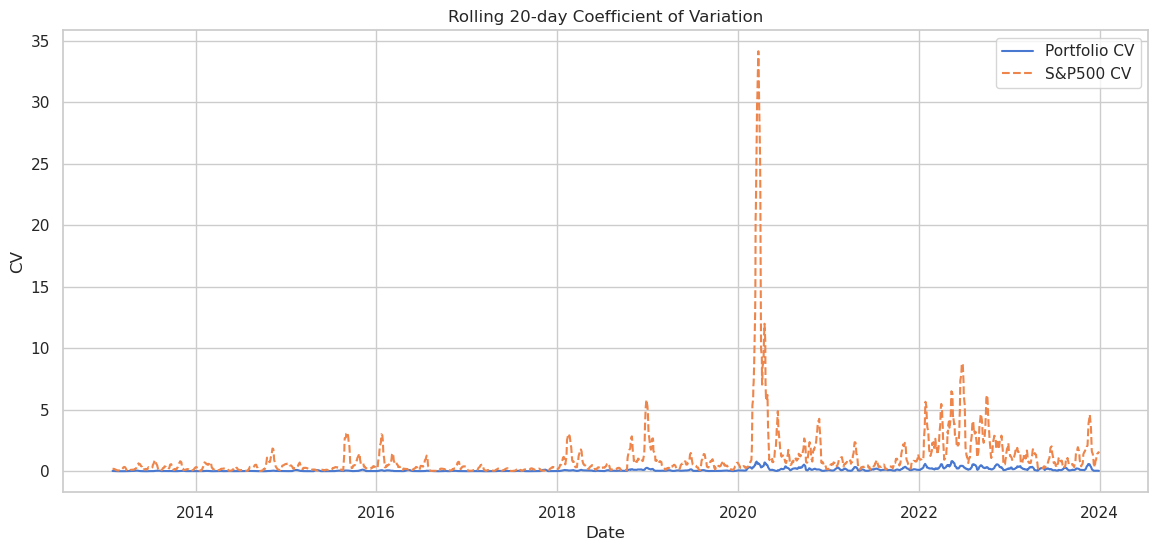

In [66]:
port_rolling_var = portfolio_prices.rolling(window).var().mean(axis=1)
port_rolling_mean = portfolio_prices.rolling(window).mean().mean(axis=1)
cv_rolling_port = port_rolling_var / port_rolling_mean

sp_rolling_var = sp500_prices.rolling(window).var()
sp_rolling_mean = sp500_prices.rolling(window).mean()
cv_rolling_sp = sp_rolling_var / sp_rolling_mean

plt.figure(figsize=(14,6))
plt.plot(cv_rolling_port, label="Portfolio CV")
plt.plot(cv_rolling_sp, label="S&P500 CV", linestyle="--")
plt.title(f"Rolling {window}-day Coefficient of Variation")
plt.xlabel("Date")
plt.ylabel("CV")
plt.legend()
plt.show()


## Rolling Returns
Calculate returns over a rolling window


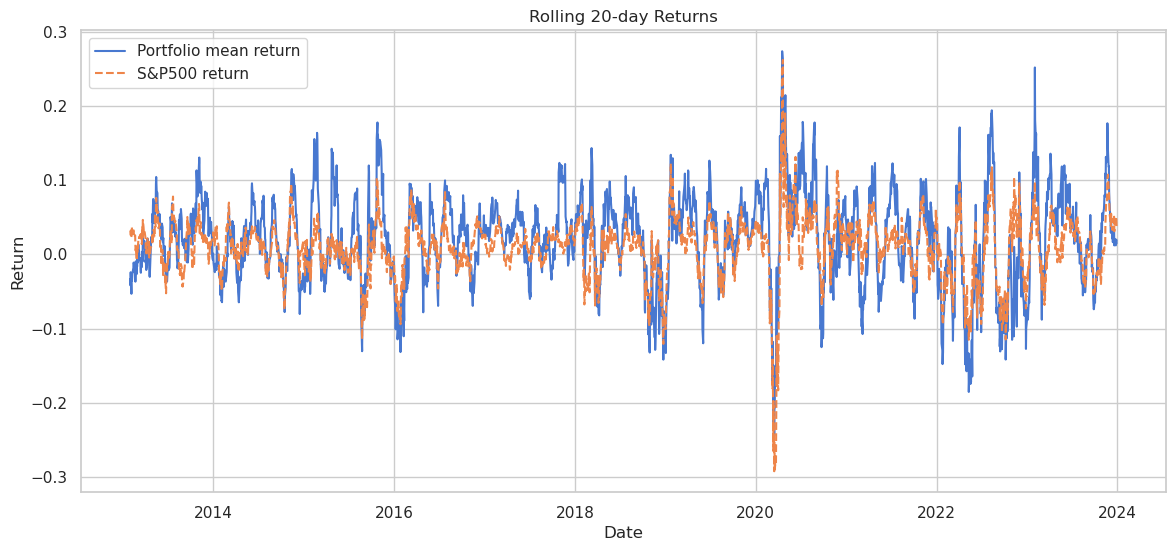

In [67]:
def block_return(block):
    return (block.iloc[-1] - block.iloc[0]) / block.iloc[0]

r_port = portfolio_prices.rolling(window).apply(block_return)
r_port_mean = r_port.mean(axis=1)
r_sp500 = sp500_prices.rolling(window).apply(block_return)

plt.figure(figsize=(14,6))
plt.plot(r_port_mean, label="Portfolio mean return")
plt.plot(r_sp500, label="S&P500 return", linestyle="--")
plt.title(f"Rolling {window}-day Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()

## Rolling Sharpe Ratio
Sharpe ratio = return adjusted for risk

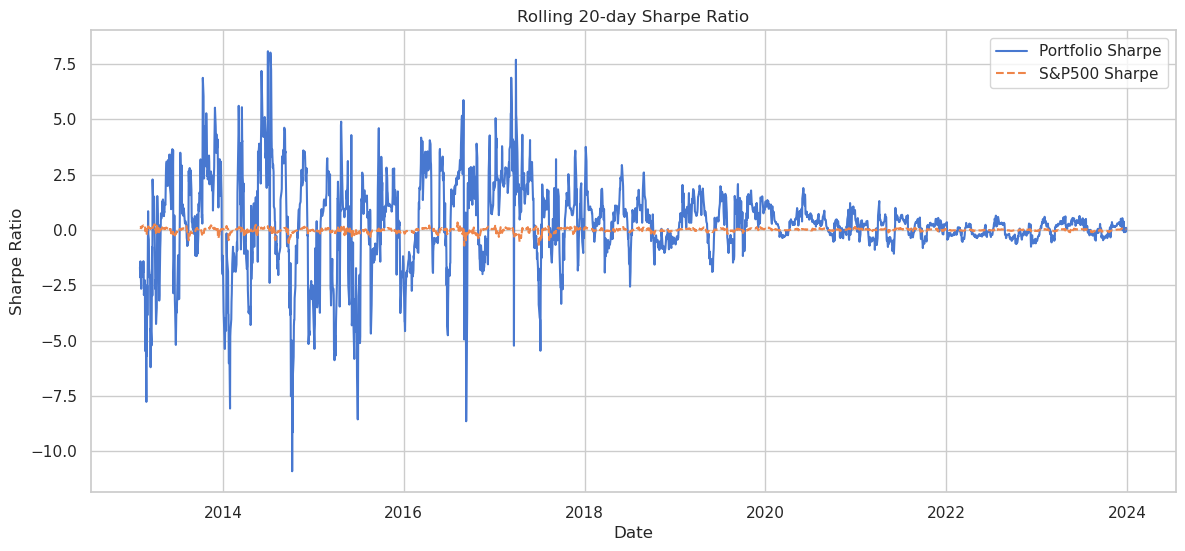

In [68]:
sharpe_port = (r_port_mean - rf['^TNX'].reindex(r_port_mean.index)) / cv_rolling_port
sharpe_sp500 = (r_sp500 - rf['^TNX'].reindex(r_sp500.index)) / cv_rolling_sp

plt.figure(figsize=(14,6))
plt.plot(sharpe_port, label="Portfolio Sharpe")
plt.plot(sharpe_sp500, label="S&P500 Sharpe", linestyle="--")
plt.title(f"Rolling {window}-day Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.show()

## Rolling Covariance
Rolling covariance between portfolio and benchmark

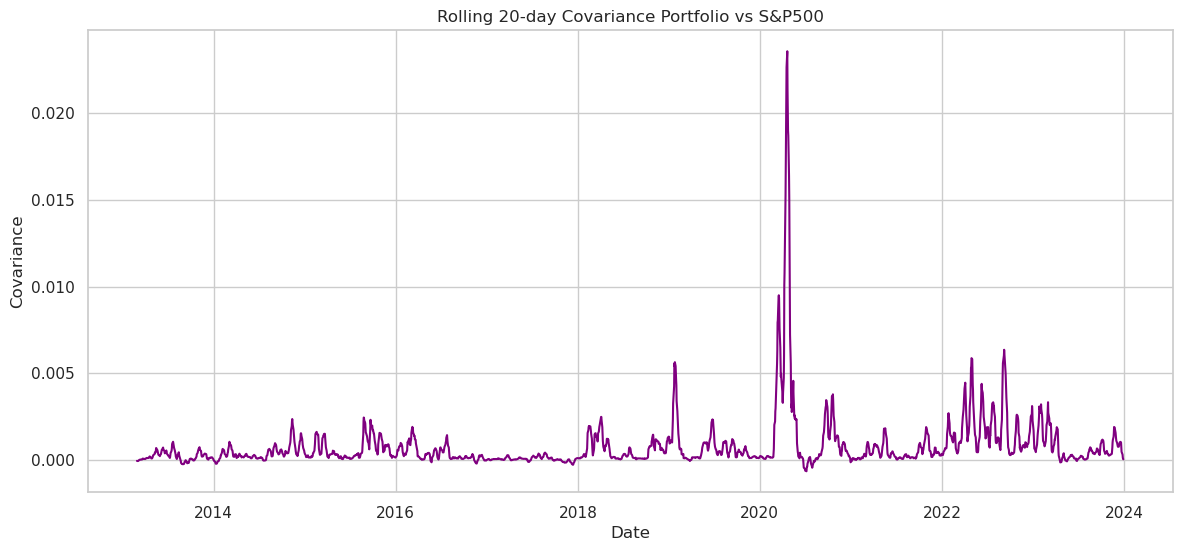

In [69]:
df_rend = pd.concat([r_port_mean, r_sp500], axis=1)
df_rend.columns = ['portfolio', 'sp500']

cov_by_block = df_rend['portfolio'].rolling(window).cov(df_rend['sp500'])

plt.figure(figsize=(14,6))
plt.plot(cov_by_block, color="purple")
plt.title(f"Rolling {window}-day Covariance Portfolio vs S&P500")
plt.xlabel("Date")
plt.ylabel("Covariance")
plt.show()

## Binary Indicator: Portfolio Outperforms S&P500

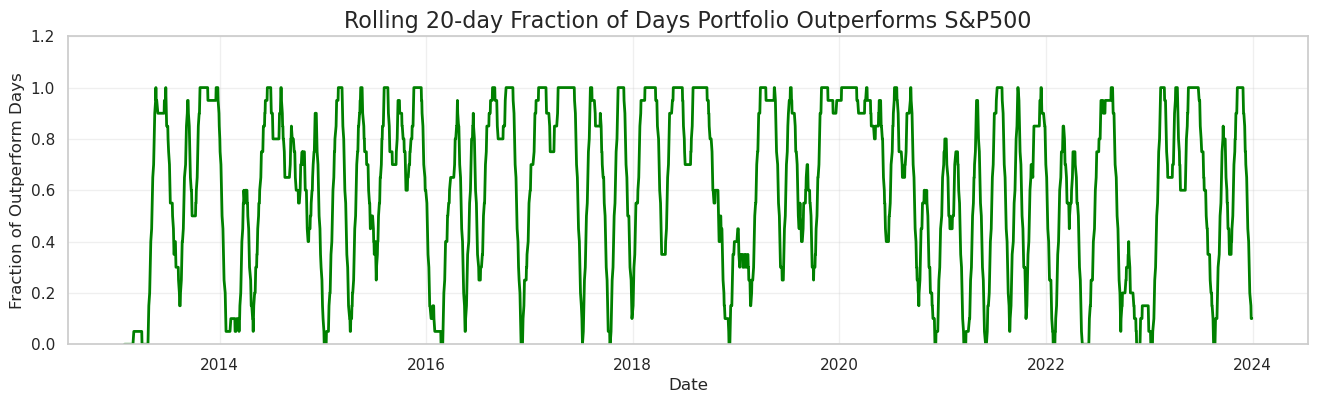

Percentage of days portfolio > S&P500: 61.13%


In [70]:
r_port_21 = portfolio_prices.rolling(window+1).apply(block_return)
r_port_mean_21 = r_port.mean(axis=1)
r_sp500_21 = sp500_prices.rolling(window+1).apply(block_return)
result = (r_port_mean_21 > r_sp500_21).astype(int)

rolling_result = result.rolling(window=20).mean()  # 20-day rolling fraction

plt.figure(figsize=(16,4))
plt.plot(rolling_result, color='green', linewidth=2)
plt.title("Rolling 20-day Fraction of Days Portfolio Outperforms S&P500", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Fraction of Outperform Days")
plt.ylim(0,1.2)
plt.grid(alpha=0.3)
plt.show()


print(f"Percentage of days portfolio > S&P500: {result.mean()*100:.2f}%")

## Distribution of Rolling Sharpe Ratios

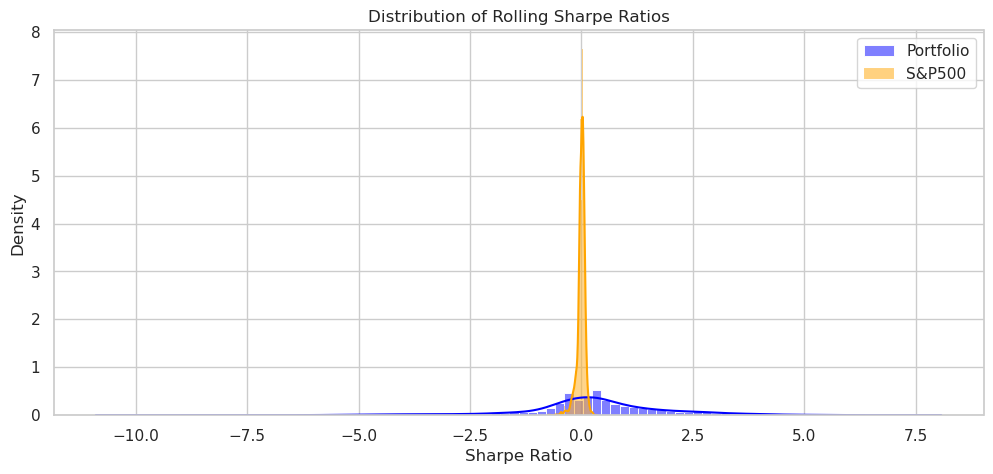

In [71]:
plt.figure(figsize=(12,5))
sns.histplot(sharpe_port, color="blue", label="Portfolio", kde=True, stat="density")
sns.histplot(sharpe_sp500, color="orange", label="S&P500", kde=True, stat="density")
plt.title("Distribution of Rolling Sharpe Ratios")
plt.xlabel("Sharpe Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()
